# Take-Home Challenge: Relax Inc.

The data is available as two attached CSV files:
`takehome_user_engagement.csv` 
`takehome_users.csv`
The data has the following two tables:

**1.** A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
- **name**: the user's name
- **object_id**: the user's id
- **email**: email address
- **creation_source**: how their account was created. This takes on one of 5 values:
  - **PERSONAL_PROJECTS**: invited to join another user's personal workspace
  - **GUEST_INVITE**: invited to an organization as a guest (limited permissions)
  - **ORG_INVITE**: invited to an organization (as a full member)
  - **SIGNUP**: signed up via the website
  - **SIGNUP_GOOGLE_AUTH**: signed up using Google
Authentication (using a Google email account for their login id)
- **creation_time**: when they created their account
- **last_session_creation_time**: unix timestamp of last login
- **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
- **enabled_for_marketing_drip**: whether they are on the regular marketing email drip
- **org_id**: the organization (group of users) they belong to
- **invited_by_user_id**: which user invited them to join (if applicable).

**2.** A usage summary table ( "*takehome_user_engagement*" ) that has a row for each day
that a user logged into the product. Defining an "*adopted user*" as a user who *has logged into the product on three separate days in at least one sevenday period*, **identify which factors predict future user adoption**.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better —no
more than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
file1 = 'takehome_user_engagement.csv'
file2 = 'takehome_users.csv'

In [3]:
df = pd.read_csv(file2, encoding='ISO-8859-1')
df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0


Filling the missing values:

In [4]:
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())
df['invited_by_user_id'] = df['invited_by_user_id'].fillna(0)

#invited_by_user could be boolean:
df['invited_by_user_id'] = np.where(df['invited_by_user_id']!=0, 1, 0)

In [5]:
df_time = pd.read_csv(file1)
df_time.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


`df['adopted_user']` can be defined as a label: a user who has logged into the product on three separate days in at least one sevenday period (1), or not (0).
In order to find this, we can iterate over the list of users, and for each user we go over the list of login times. The condition is if there is any 3 consecutive login days, which the delta time is equal of less than 7. And if so we can label that user as 1 and break the loop —one such delta time is enough for a user so we do not need to continue.

In [6]:
count_list = []
for i in range(1, 12001):
    count = 0
    for j in range( len(df_time[df_time['user_id']==i])  -2):
                               delta = pd.to_datetime(list(df_time[df_time['user_id']==i]['time_stamp'])[j+2])\
                               - pd.to_datetime(list(df_time[df_time['user_id']==i]['time_stamp'])[j])
                               if delta.days <= 7:
                                   count +=1
                                   break
    count_list.append(count)
                                  
df['adopted_user']=count_list                    

Converting the last session creation time to a datetime value:

In [7]:
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'], unit='s')

In [8]:
active_time = pd.to_datetime(df['last_session_creation_time']) - pd.to_datetime(df['creation_time'])
active_time_int = []
for i in range(len(active_time)):
    active_time_int.append(active_time[i].days)
df['active_time'] = active_time_int

We also made a new column `df['active_time']` which is the difference between creation and last session creation time.


In [9]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,1,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,0,5


### *The first model: Logistic Regression*

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df_source = pd.get_dummies(df['creation_source'])
df_new = pd.concat([df, df_source], axis=1, join='inner')

X = df_new.drop(['adopted_user', 'name', 'email', 'creation_source', 
                 'last_session_creation_time', 'creation_time'], axis=1).values
y = df_new['adopted_user'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [11]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [12]:
adopted_user_logreg = np.count_nonzero(y_pred)/len(y_test)*100
adopted_user_real = np.count_nonzero(y)/len(y)*100

In [13]:
print('\nThe LogisticRegression predicted adopted user percentage is {:6.2f} \
      \nThe real adopted user percentage is {:6.2f}\n'.
      format(adopted_user_logreg, adopted_user_real))


The LogisticRegression predicted adopted user percentage is   8.21       
The real adopted user percentage is  13.80



In [14]:
from sklearn.metrics import classification_report

y_pred = logreg.predict(X_test)
target_names = ['non adopted_user', 'adopted_user']

print('{} LogisticRegression report {}\n'.format(15*'=', 15*'='))
print(classification_report(y_test, y_pred, target_names=target_names))

=============== LogisticRegression report ===============

                  precision    recall  f1-score   support

non adopted_user       0.90      0.96      0.93      2068
    adopted_user       0.61      0.36      0.45       332

        accuracy                           0.88      2400
       macro avg       0.76      0.66      0.69      2400
    weighted avg       0.86      0.88      0.87      2400



### *The second model: Gradient Boosting*

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
adopted_user_logreg = np.count_nonzero(y_pred_gbc)/len(y_test)*100

In [16]:
print('\nThe GradientBoostingClassifier predicted adopted user percentage is {:6.2f} \
      \nThe real adopted user percentage is {:6.2f}\n'.
      format(adopted_user_logreg, adopted_user_real))


The GradientBoostingClassifier predicted adopted user percentage is   9.21       
The real adopted user percentage is  13.80



In [17]:
print('{} GradientBoosting report {}\n'.format(15*'=', 15*'='))
print(classification_report(y_test, y_pred_gbc, target_names=target_names))

=============== GradientBoosting report ===============

                  precision    recall  f1-score   support

non adopted_user       0.93      0.98      0.95      2068
    adopted_user       0.79      0.53      0.63       332

        accuracy                           0.92      2400
       macro avg       0.86      0.75      0.79      2400
    weighted avg       0.91      0.92      0.91      2400



In [18]:
features = df_new.drop(['adopted_user', 'name', 'email', 'creation_source', 
                          'last_session_creation_time', 'creation_time'], axis=1).columns
feature_importances = pd.DataFrame(gbc.feature_importances_, index=features,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
active_time,0.840157
PERSONAL_PROJECTS,0.076942
SIGNUP_GOOGLE_AUTH,0.029414
invited_by_user_id,0.021574
org_id,0.014841
object_id,0.011577
SIGNUP,0.004626
ORG_INVITE,0.000530
enabled_for_marketing_drip,0.000326
opted_in_to_mailing_list,0.000009


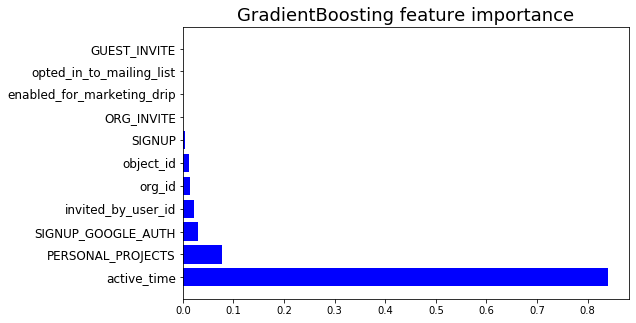

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
plt.barh(feature_importances.index, feature_importances.importance, color='b')
plt.yticks(fontsize=12)
plt.title('GradientBoosting feature importance', size=18)
plt.show()

### *Summary*

So the goal was to identify "adopted users" and to find which factors predict future user adoption. Above I showed two models `LogisticRegression` and `GradientBoostingClassifier` predicting the user adaptation based on providing data. 

We found the latter model `GradientBoostingClassifier` does a better job —higher accuracy of predicting adopted users ~79%. Then we found and plot a list of important features which shows the `active_time` has the highest contribution coefficient in future user adoption.